dict_keys(['__header__', '__version__', '__globals__', 'EEGsample', 'subindex', 'substate'])
EEG 数据形状: (2022, 30, 384)
Subindex: [[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


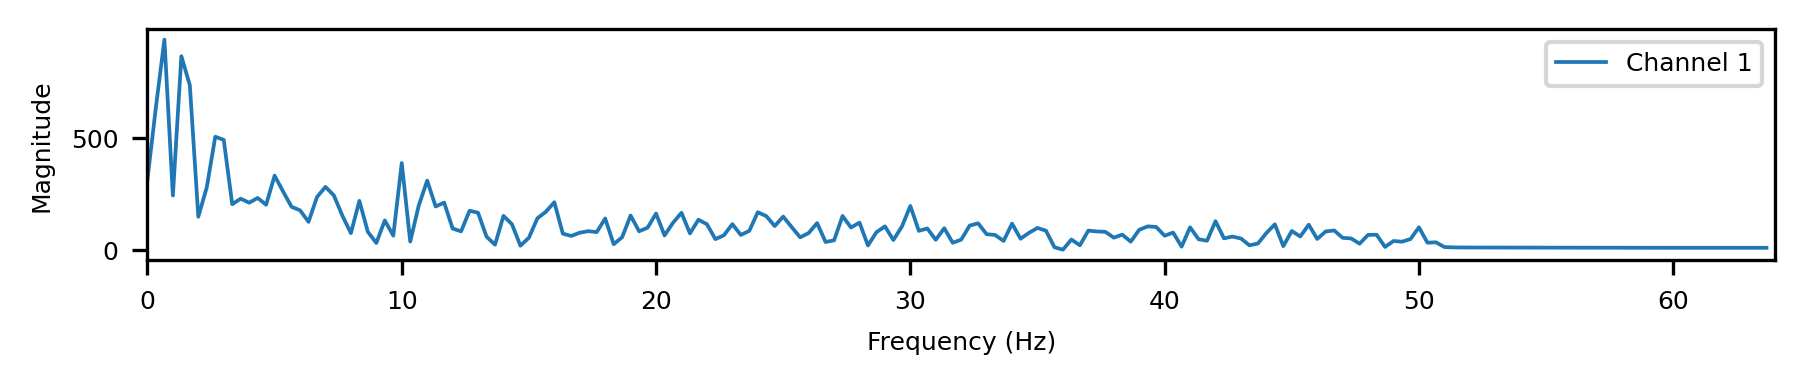

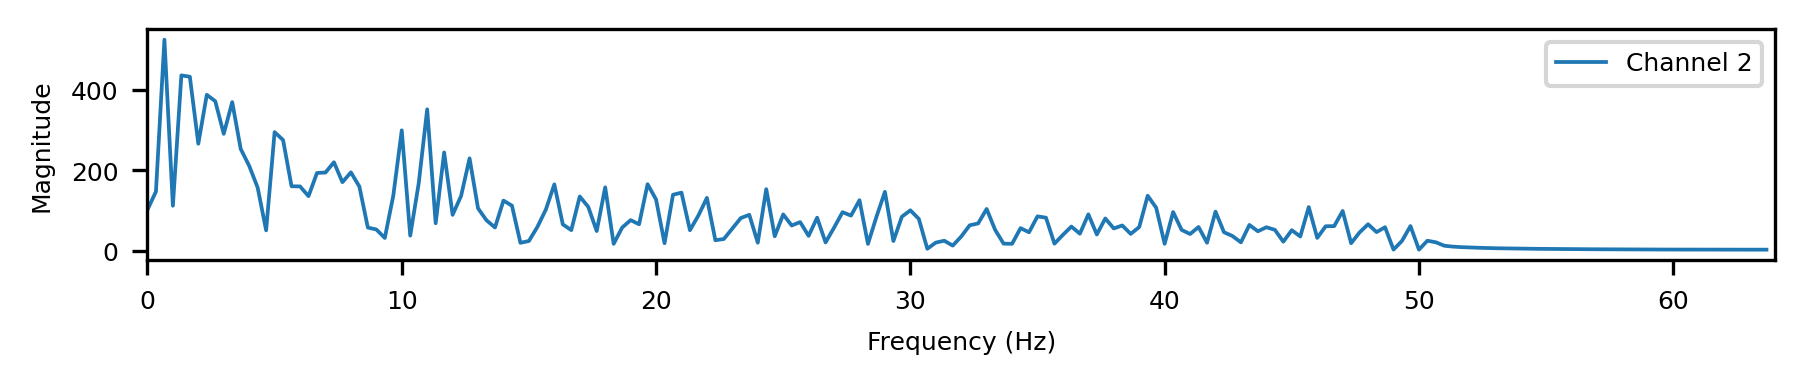

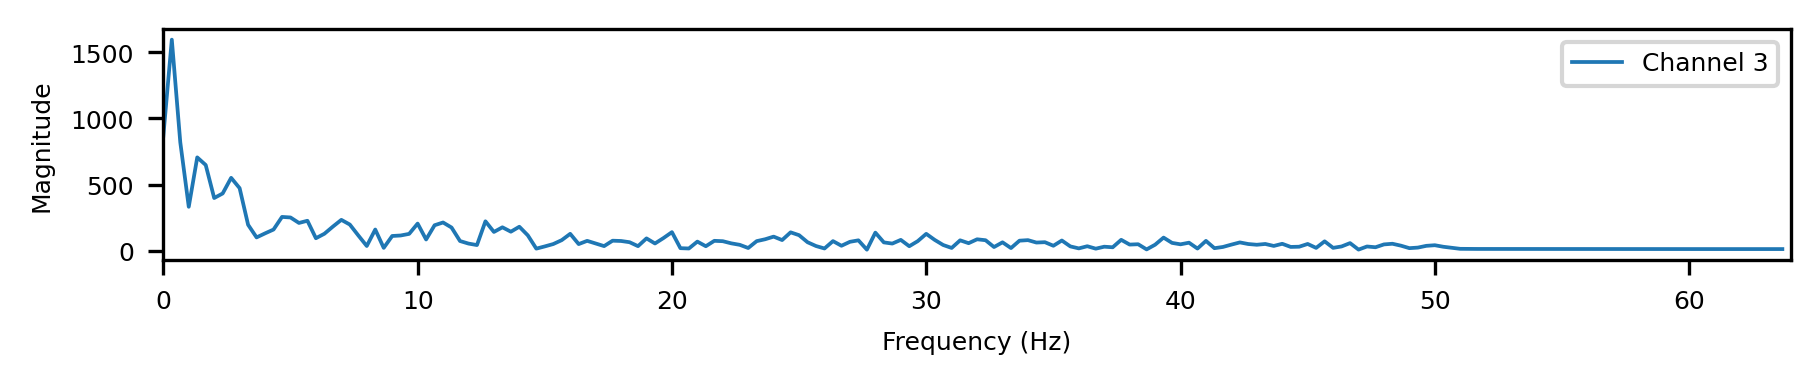

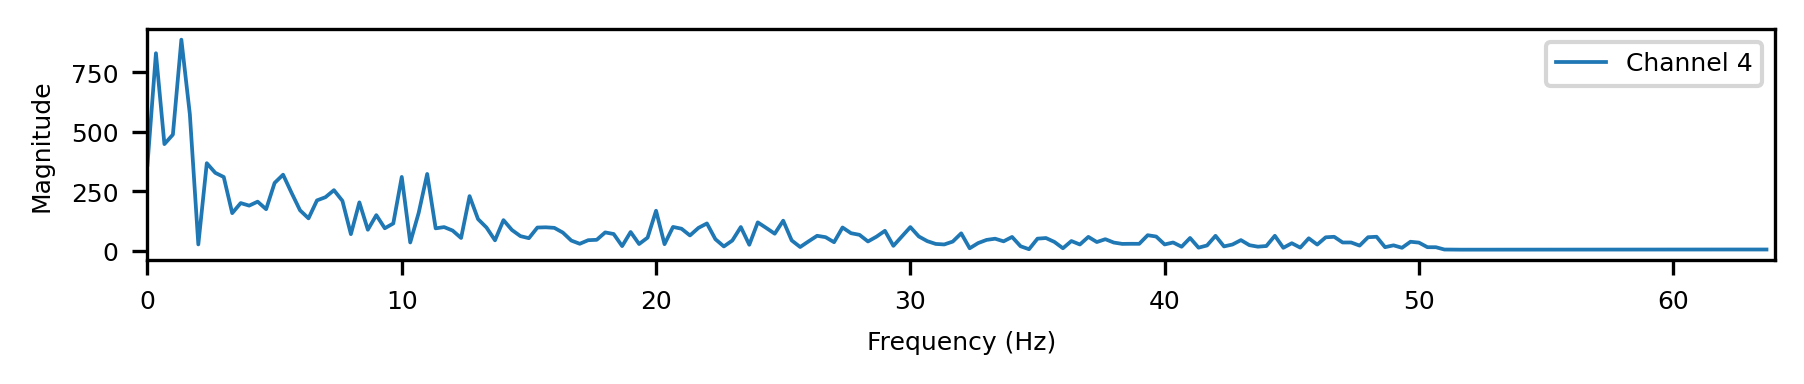

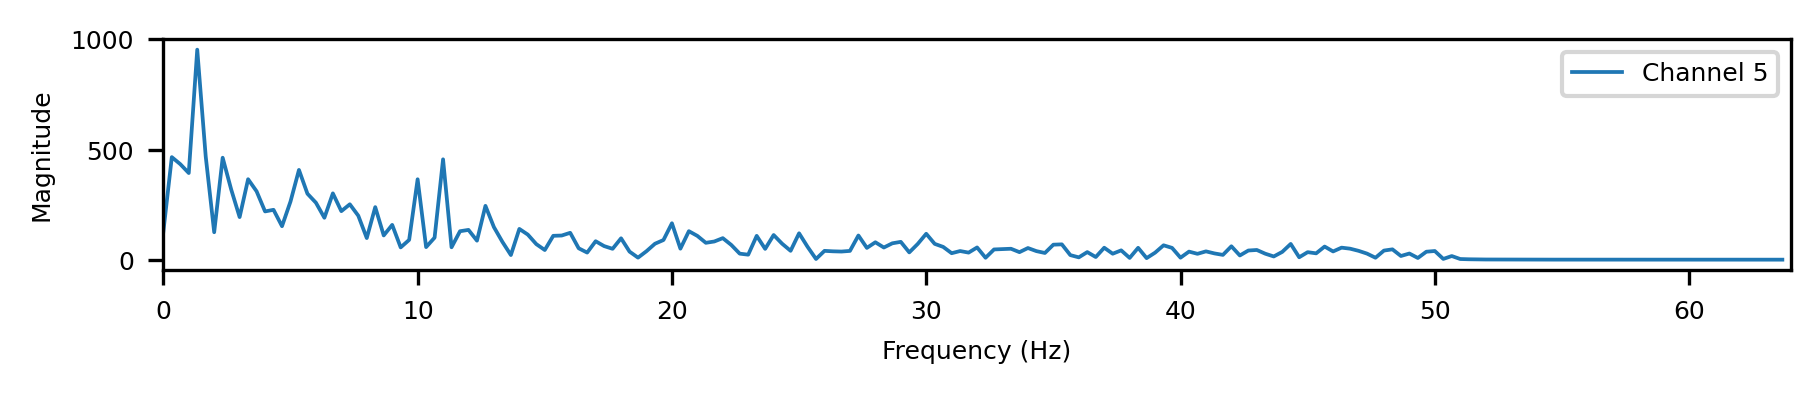

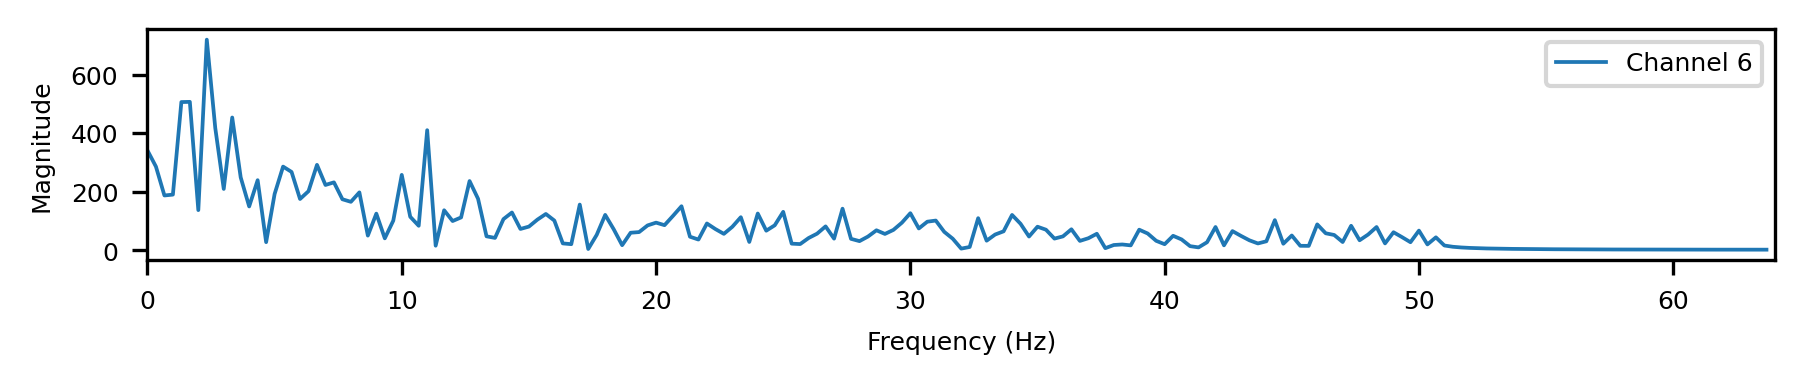

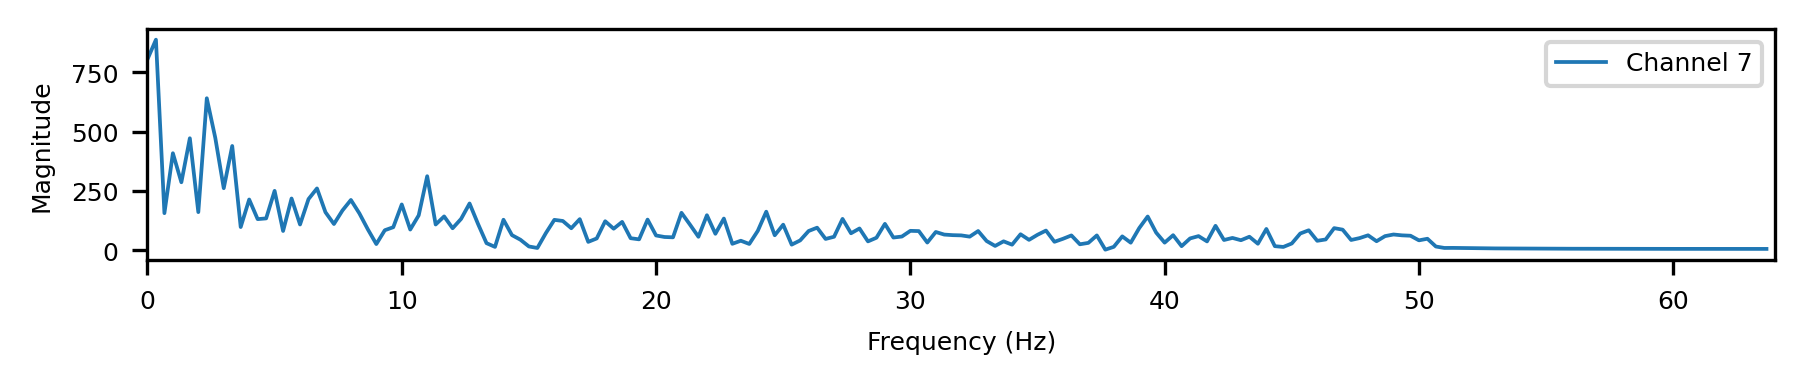

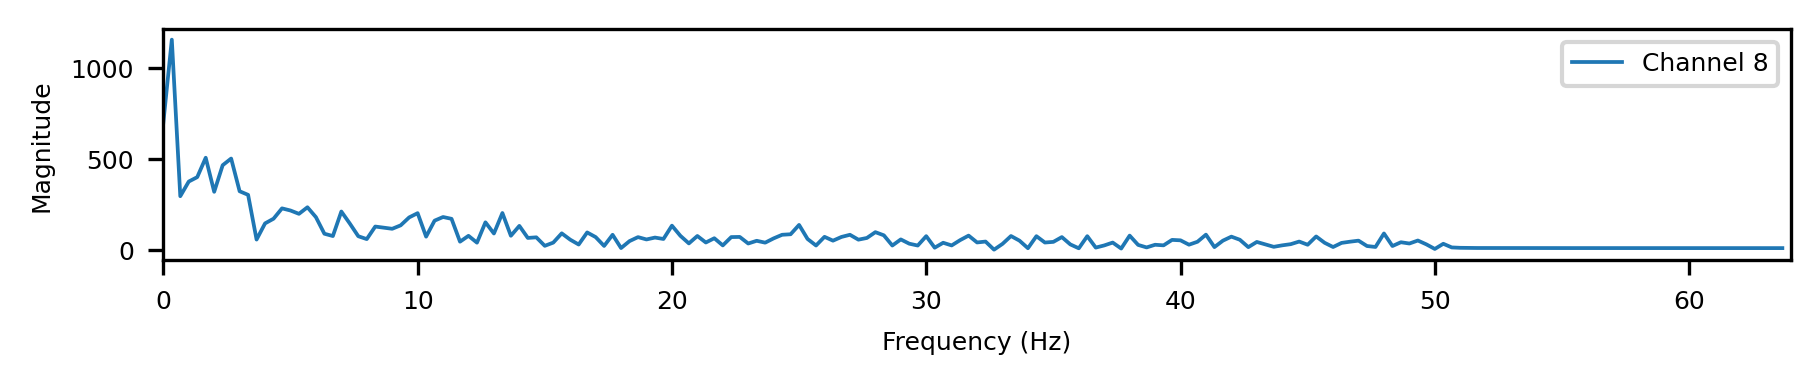

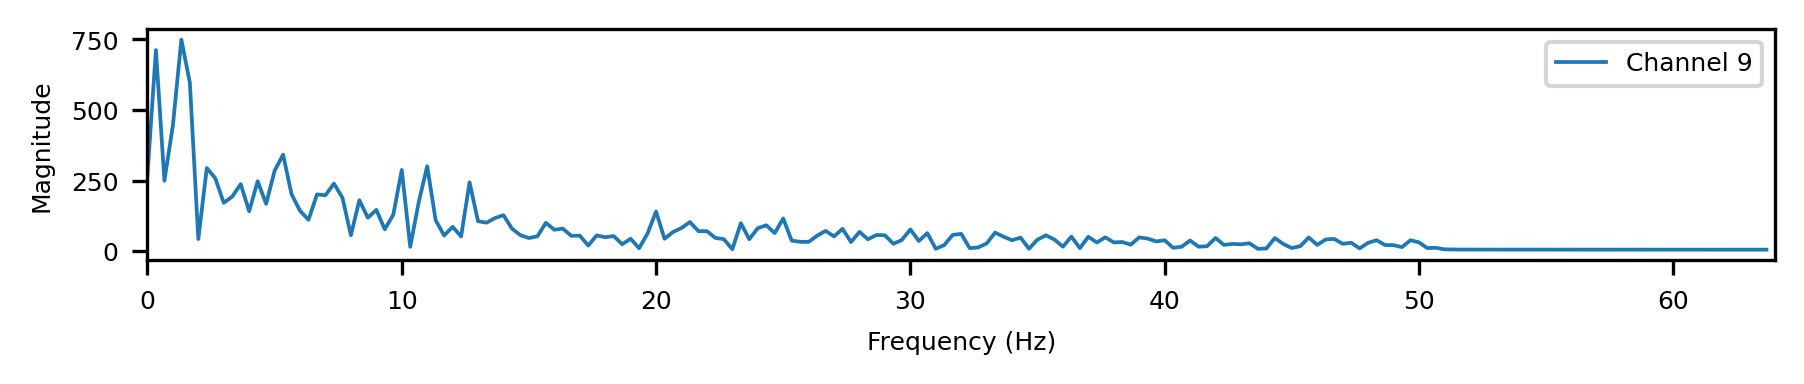

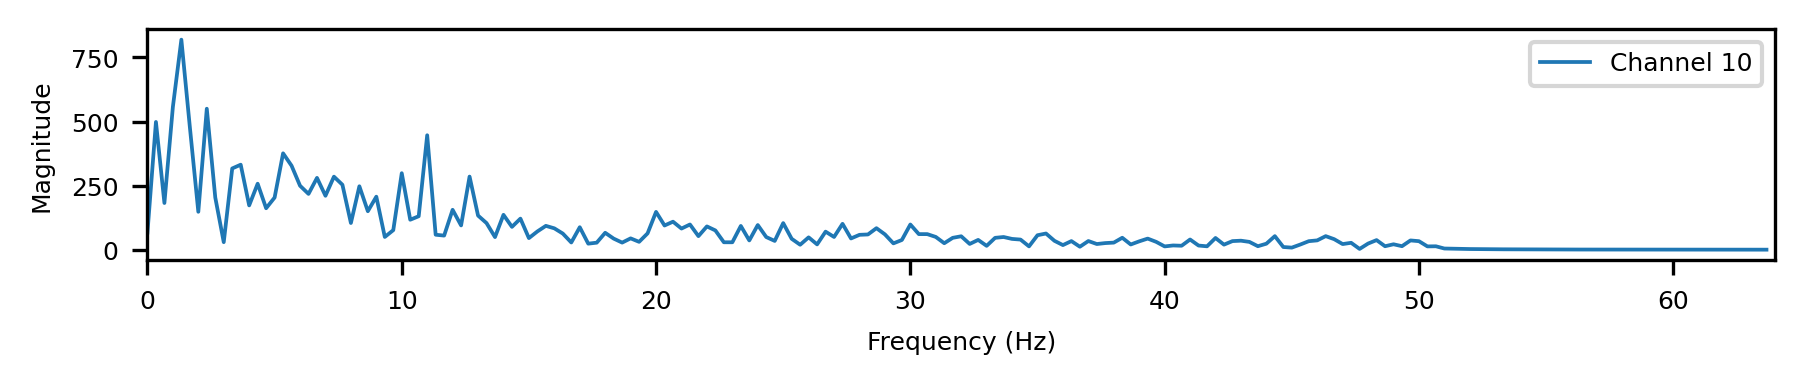

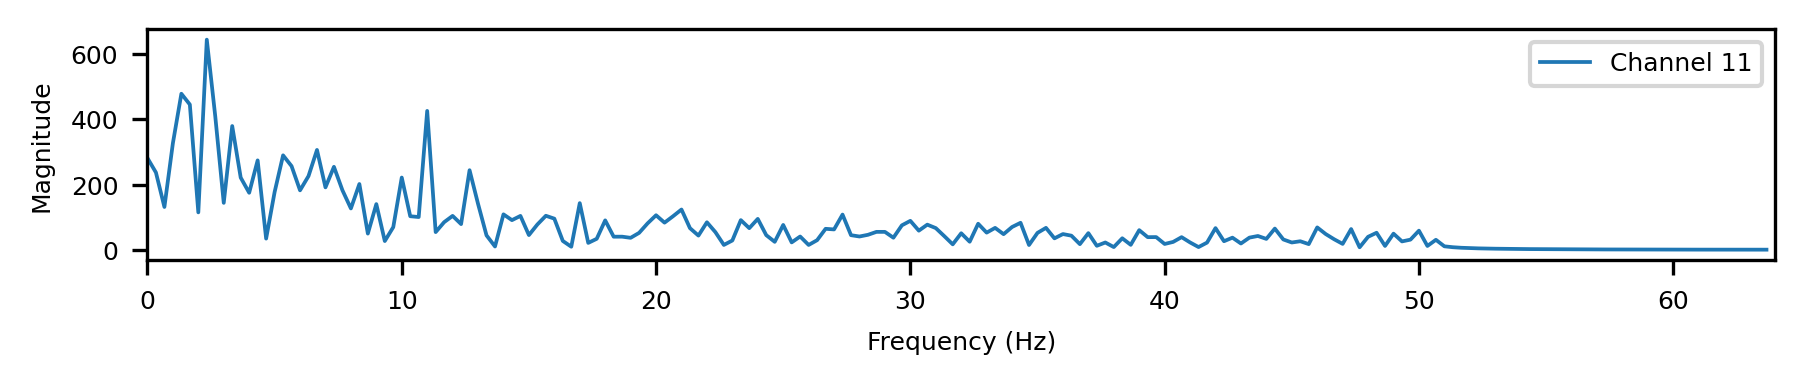

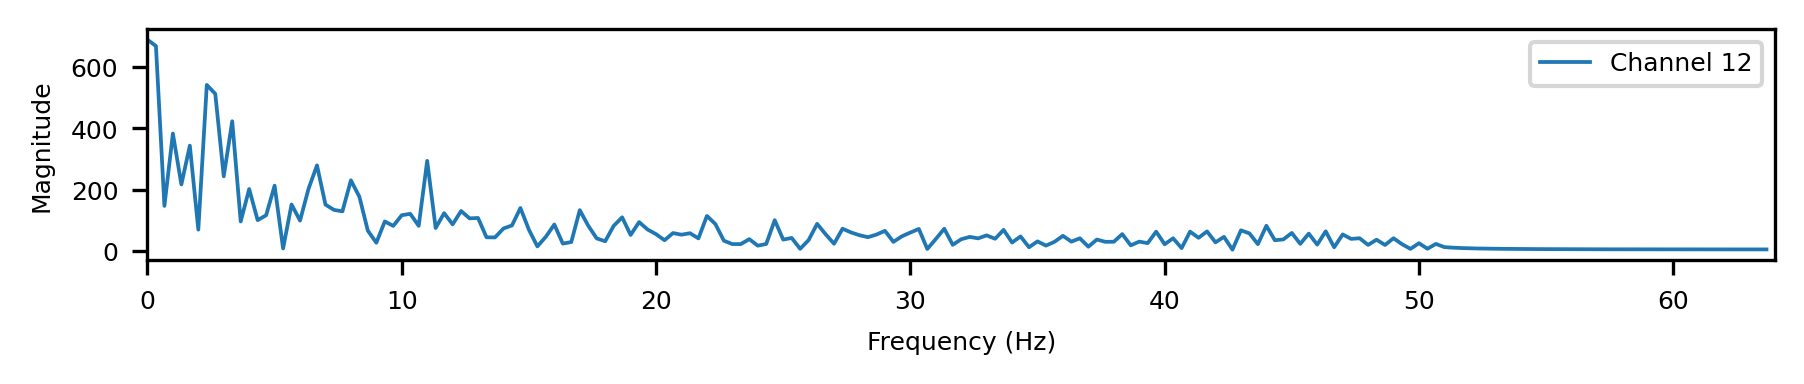

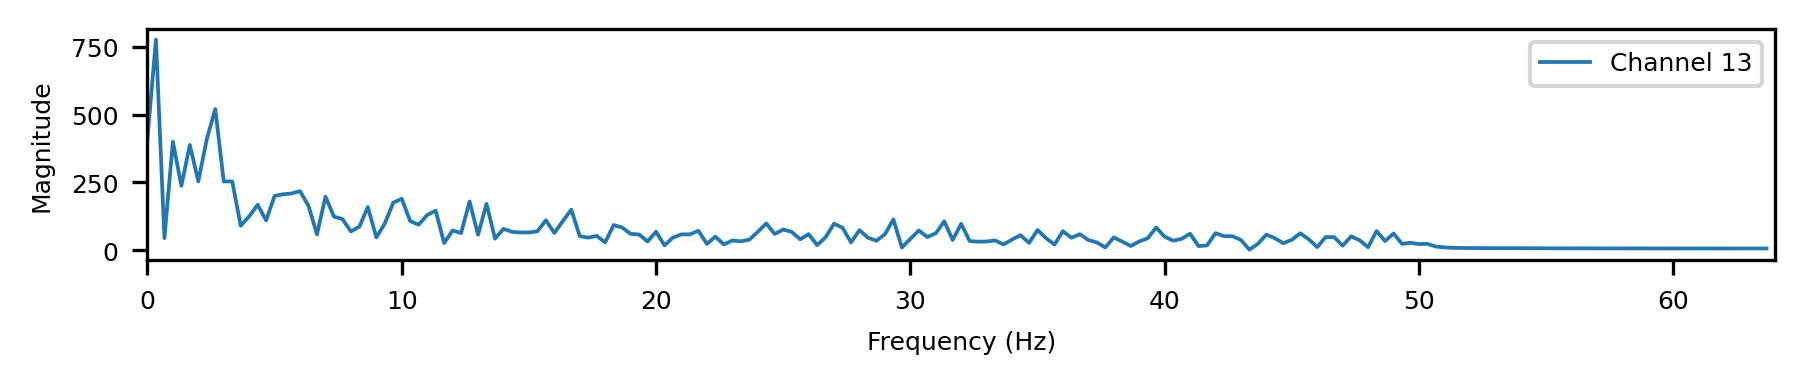

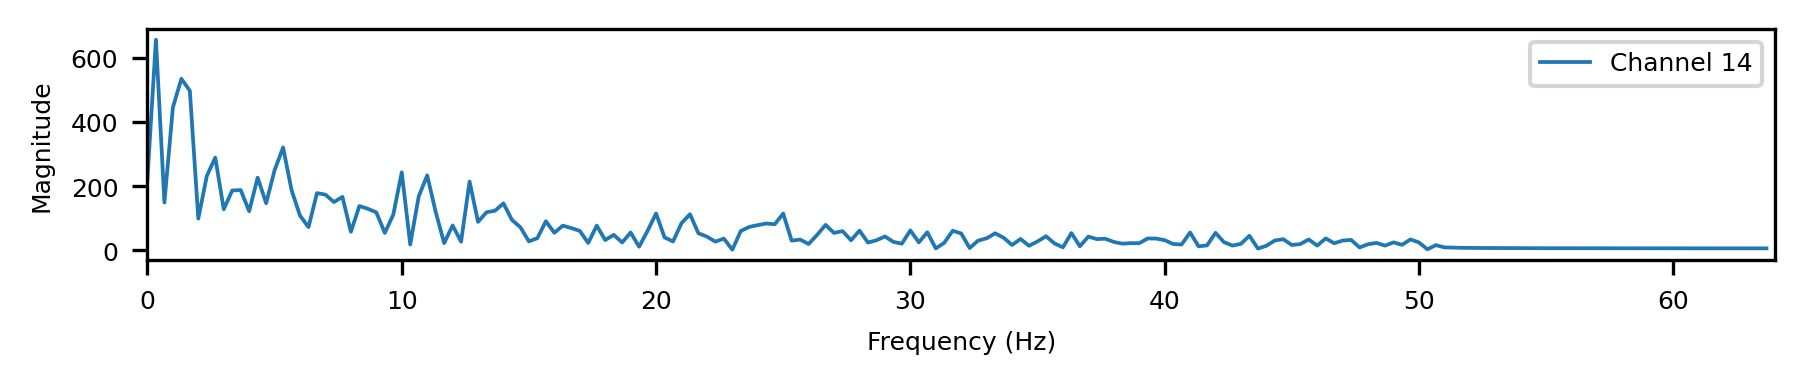

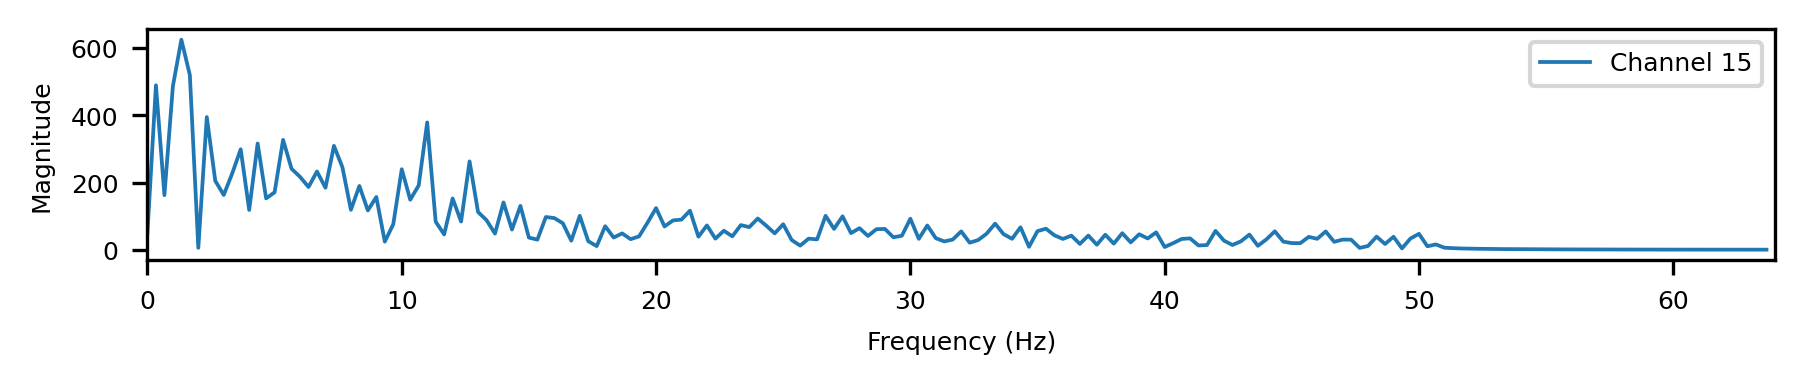

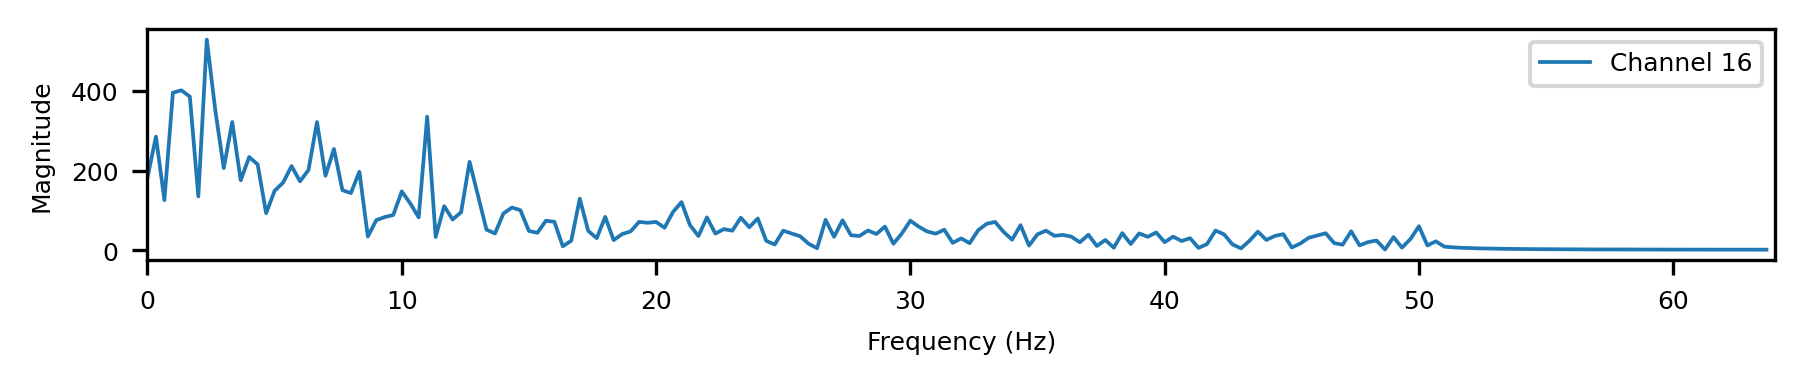

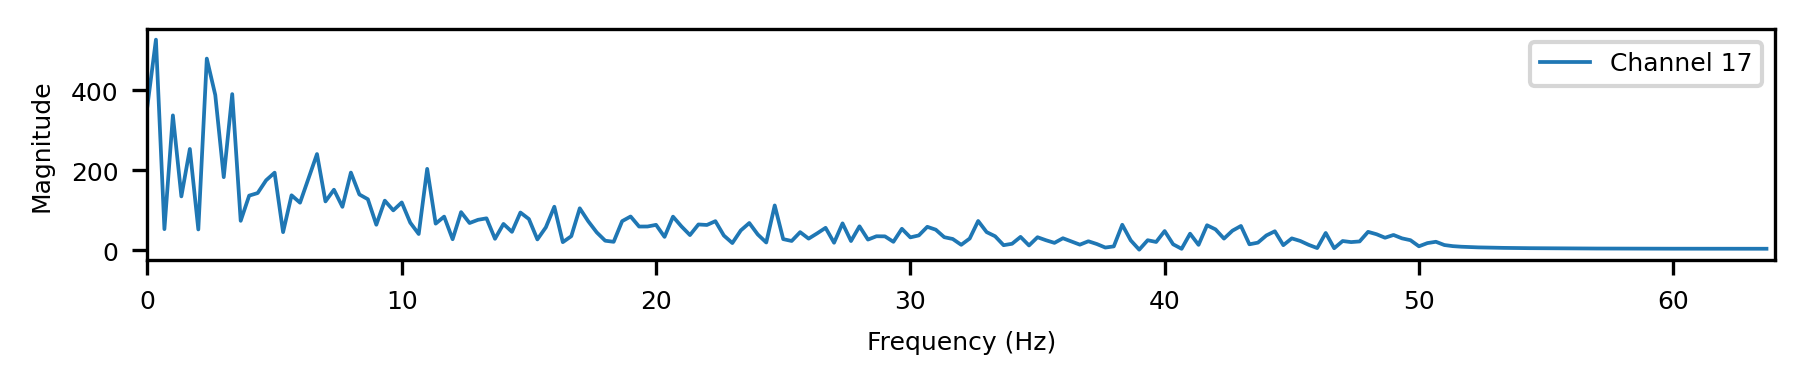

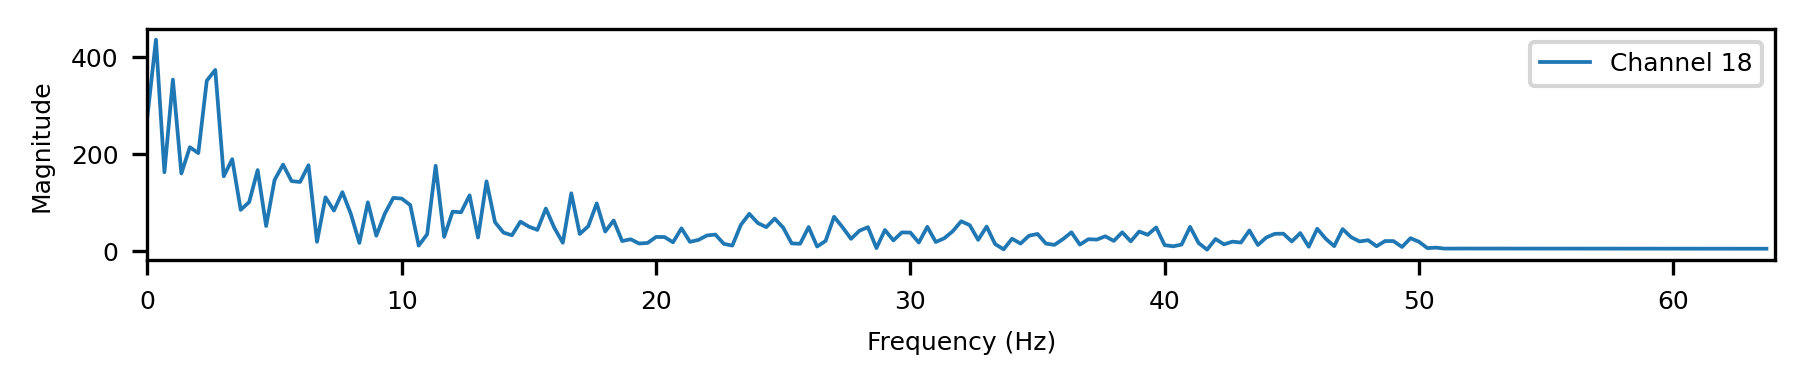

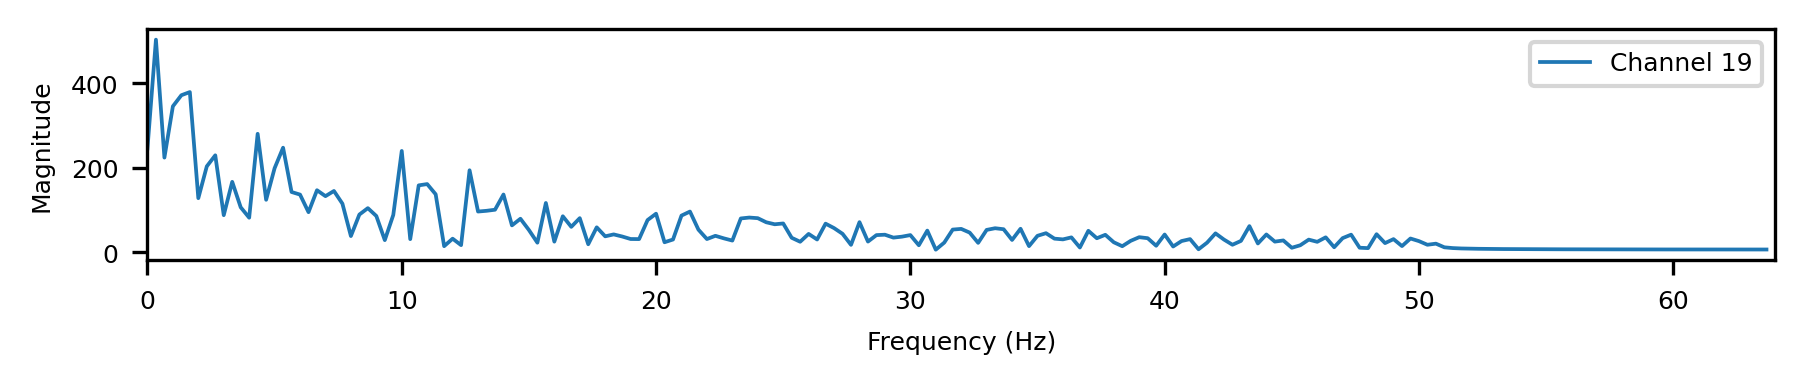

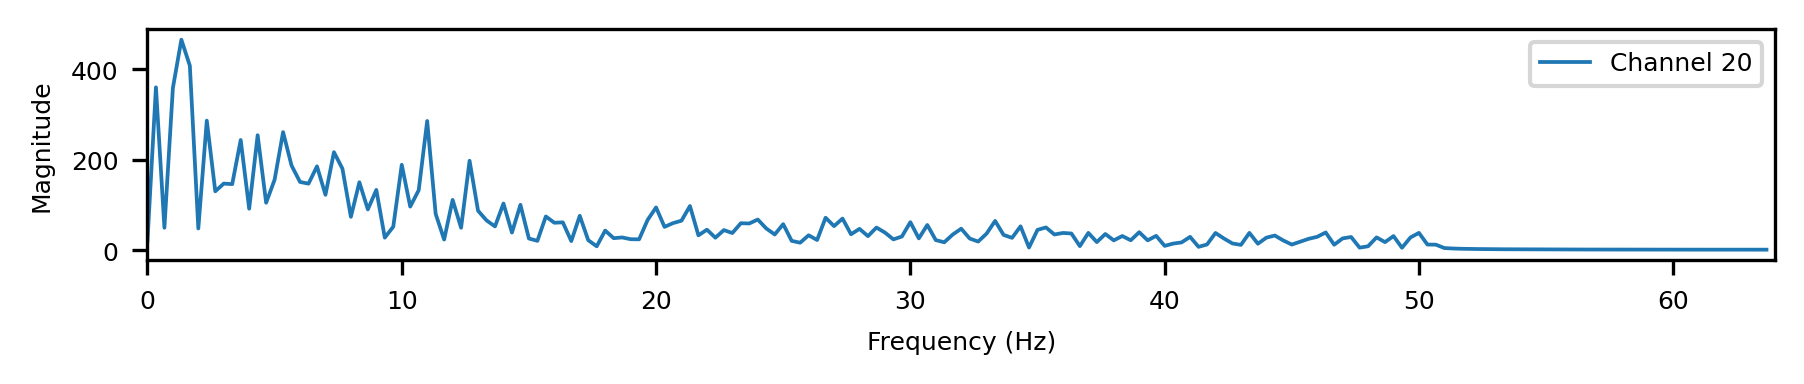

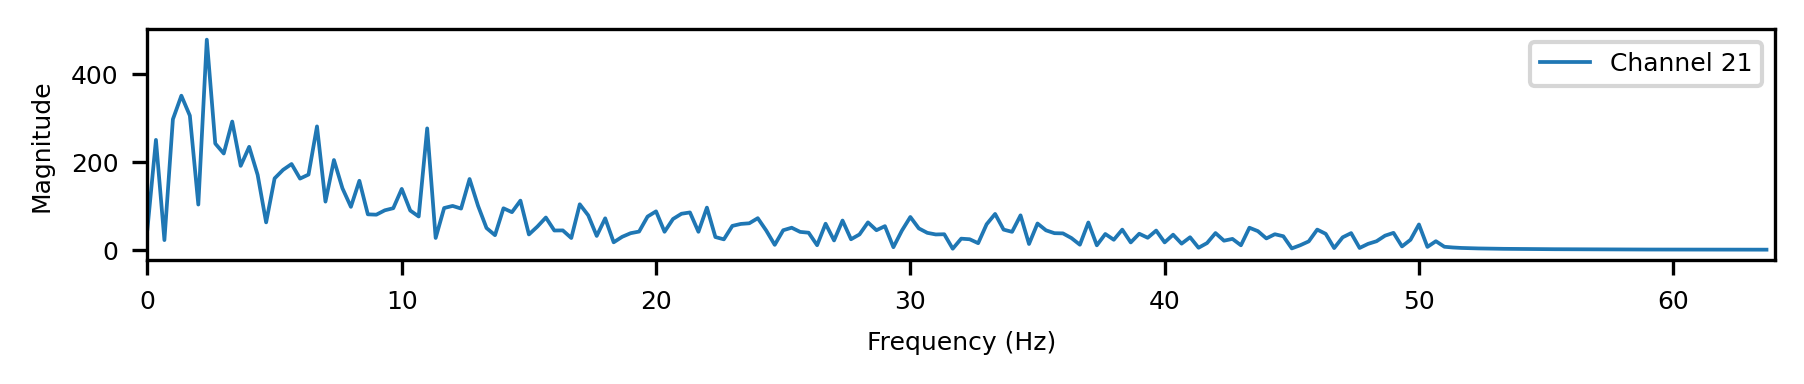

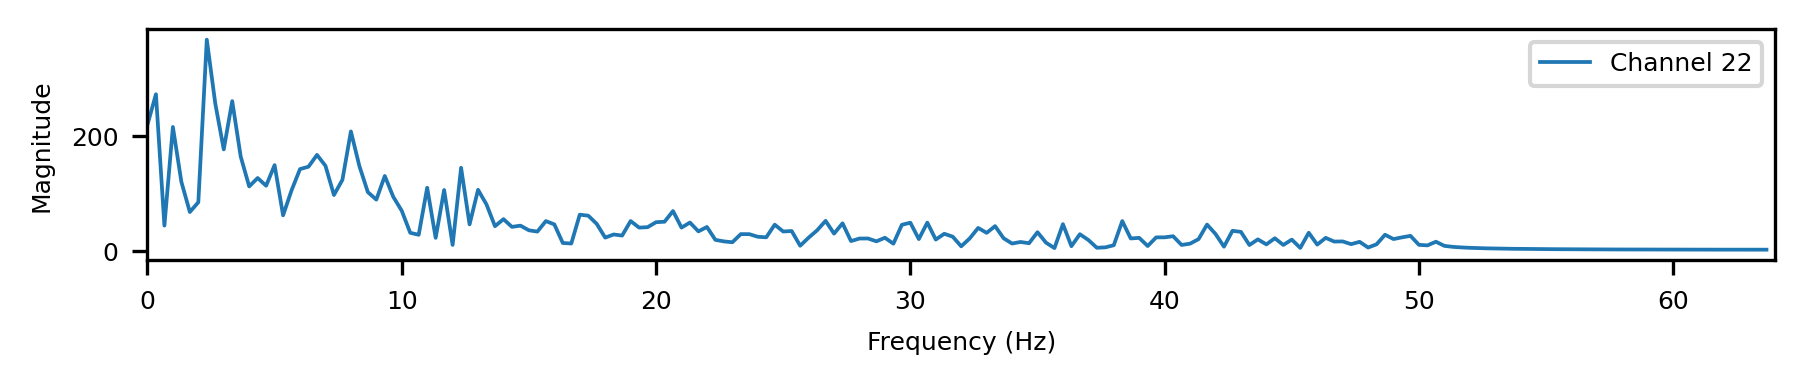

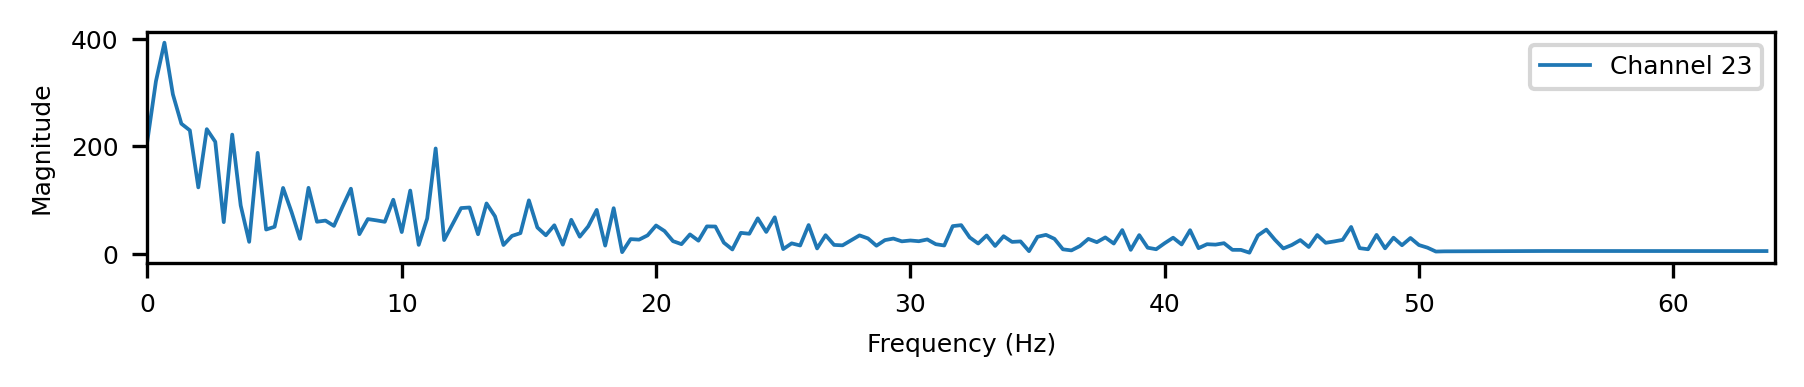

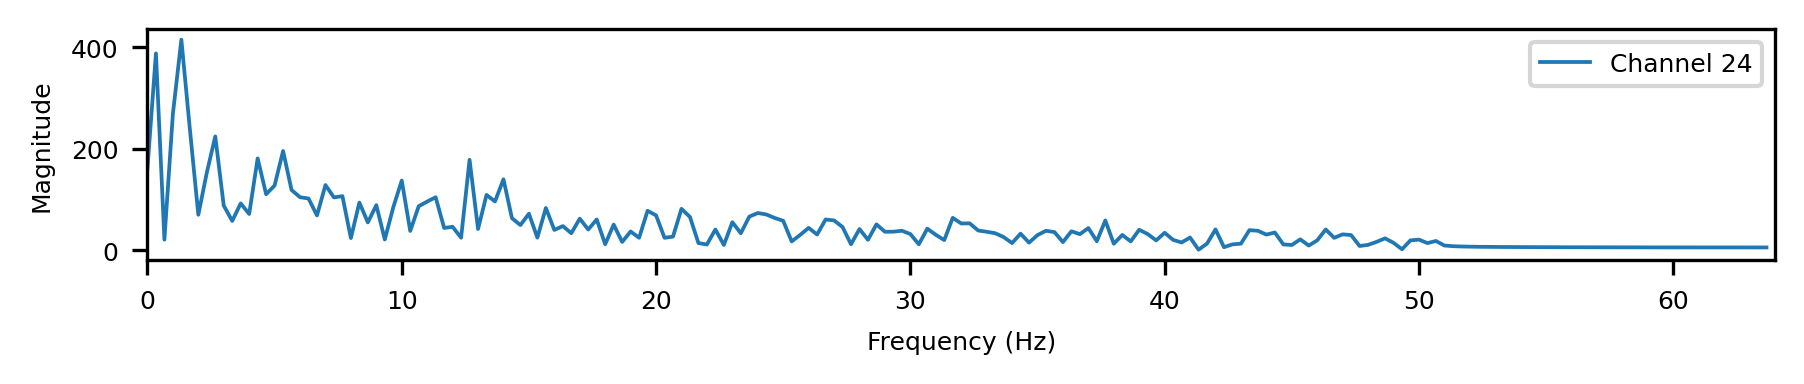

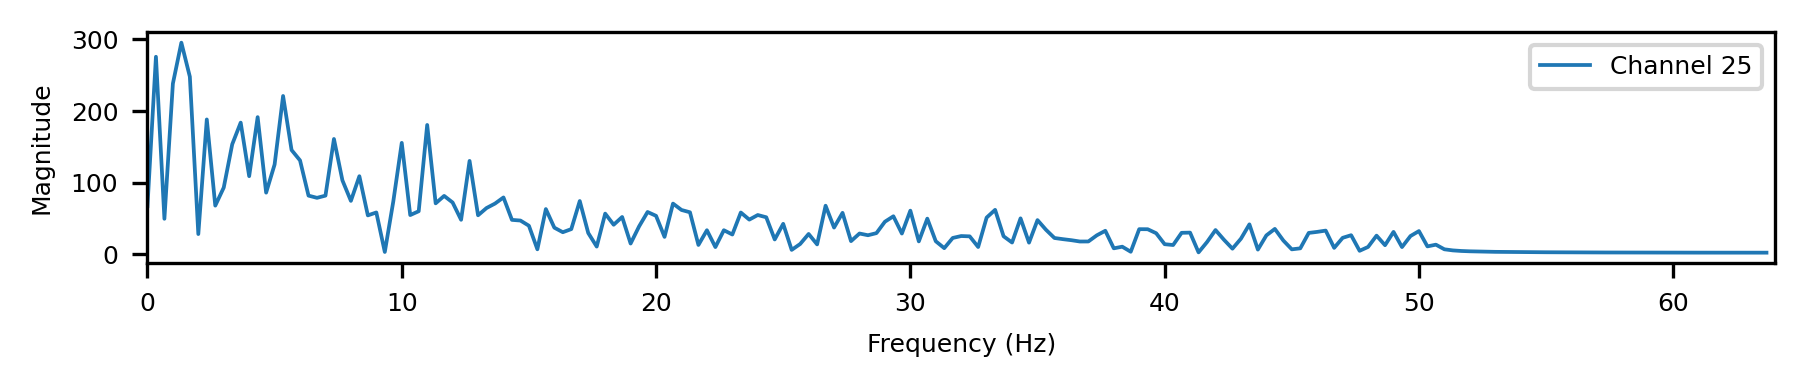

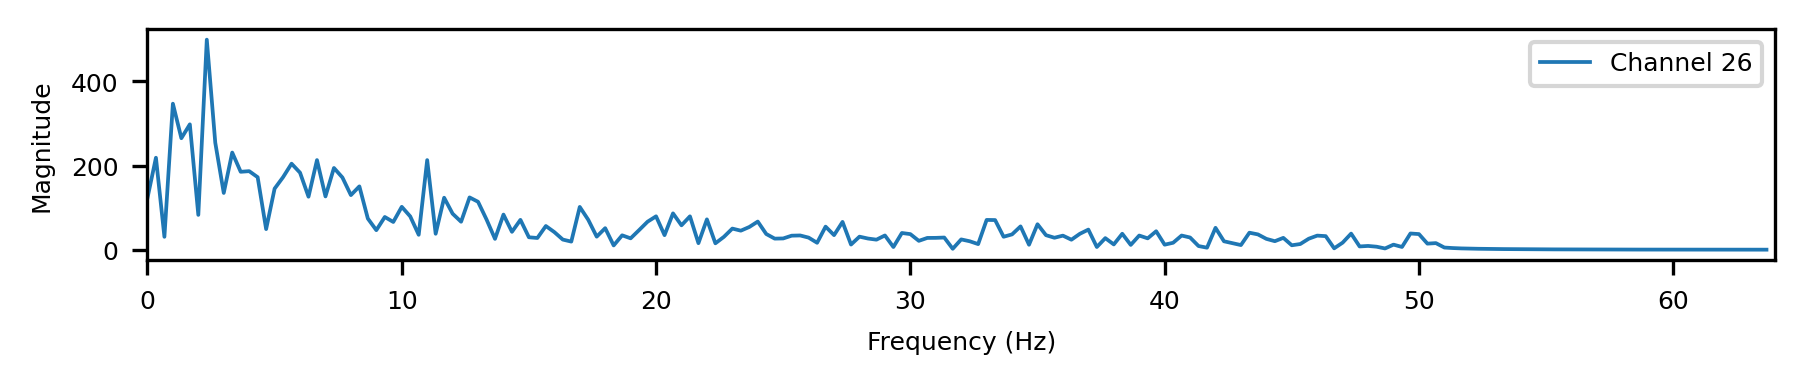

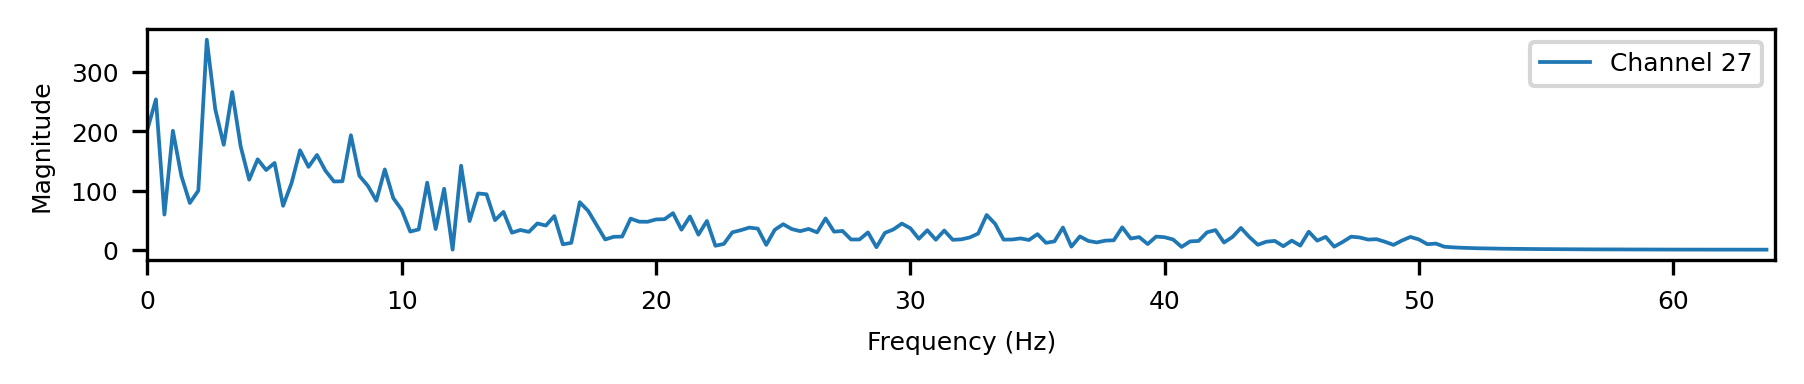

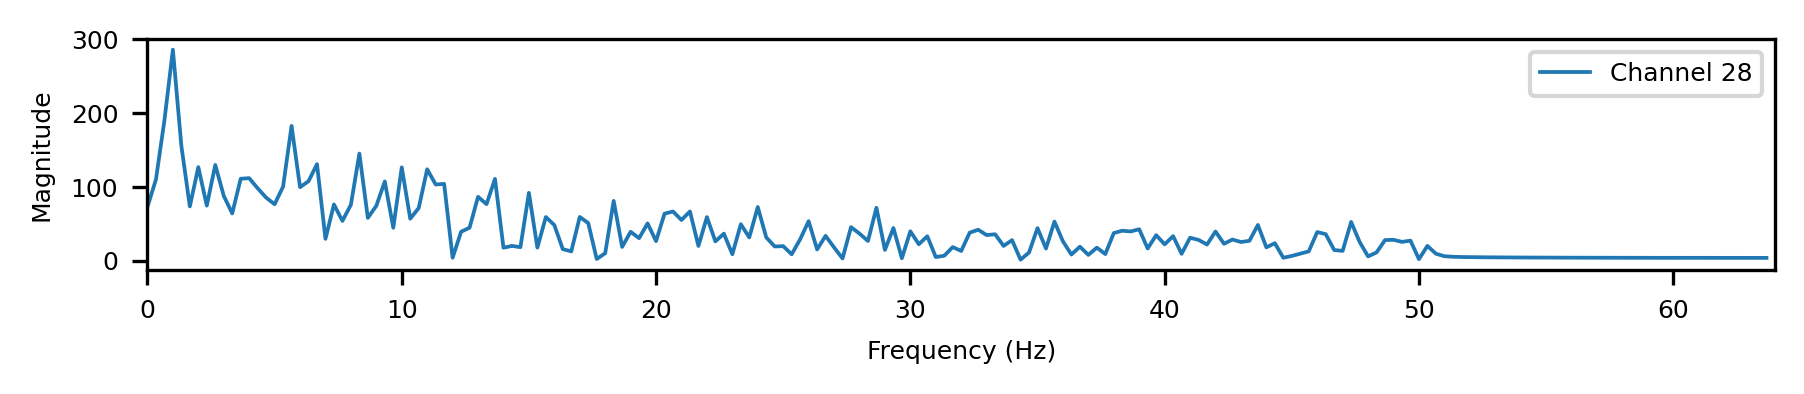

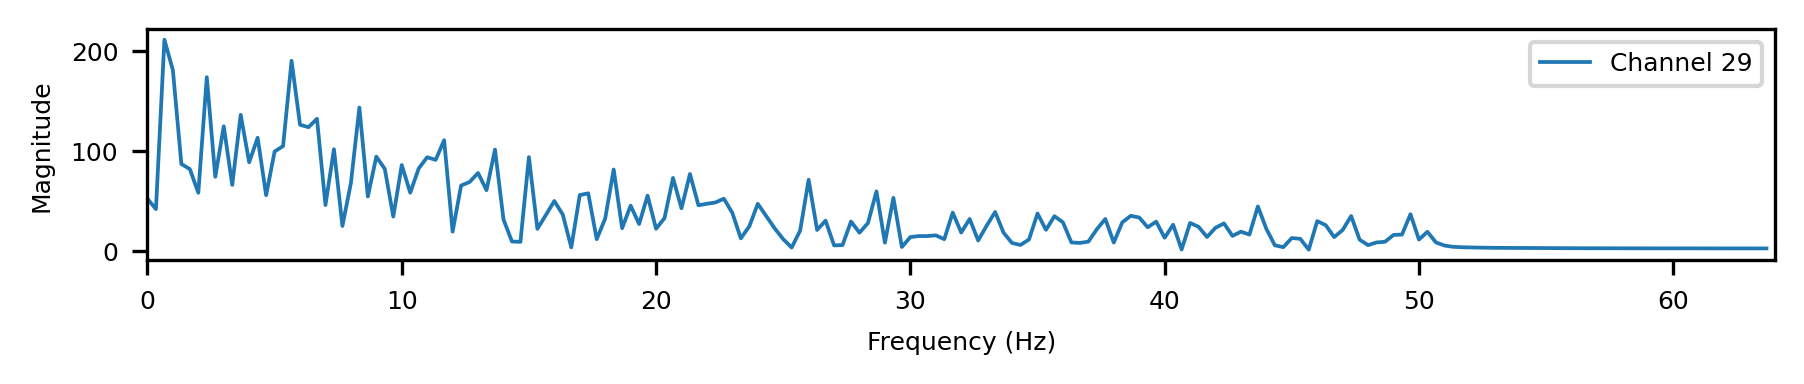

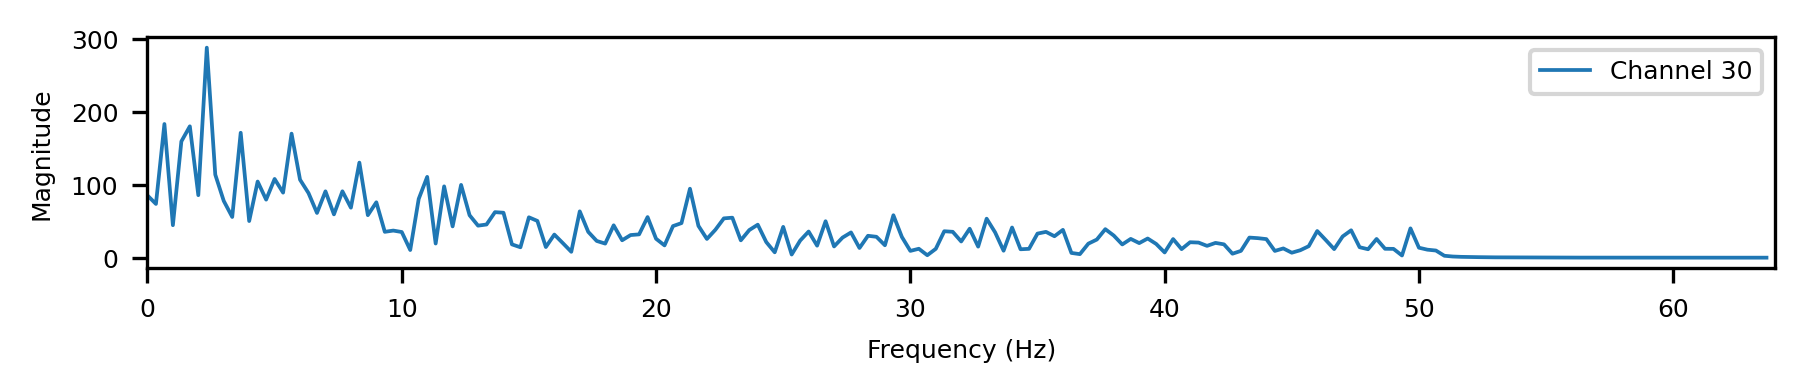

In [14]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np


# 读取 .mat 文件
mat = scipy.io.loadmat("/home/jie/Program/872/Dataset/dataset.mat")  # 替换为你的文件路径

# 查看文件中的键值
print(mat.keys())

# 假设数据在键 'EEG_data' 中
# EEG 数据通常是形状为 [通道数, 时间点数] 的 2D 数组
eeg_data = mat['EEGsample']  # 根据实际数据键名调整

# 查看数据形状
print("EEG 数据形状:", eeg_data.shape)
print("Subindex:", mat['substate'] )
# 选择每个通道的前 10 条数据
eeg_data_sample = eeg_data[-1]  # 每个通道仅取前10个时间点

# 获取采样点数量及时间轴
time_points = eeg_data_sample.shape[1]
time = np.linspace(0, time_points / 128, time_points)  # 假设采样率为128 Hz


# for i in range(30):  # 可视化前10个通道
#     plt.figure(figsize=(7, 1), dpi=300)  # 增加dpi以提高分辨率
#     plt.plot(time, eeg_data_sample[i], label=f'Channel {i+1}', linewidth=0.9)  # 减小线宽以适应高分辨率
#     plt.xlabel('', fontsize=6)  # 缩小字体大小
#     plt.ylabel('', fontsize=6)  # 缩小字体大小
#     plt.tick_params(axis='both', which='major', labelsize=6)  # 缩小刻度标签字体大小
#     #plt.title(f'EEG Signal Visualization - Channel {i+1}', fontsize=14)
#     plt.legend(prop={'size': 6})  # 缩小图例字体大小
#     plt.show()

# 绘制前几个通道的 EEG 数据
for i in range(30):  # 对30个通道进行FFT变换
    # 进行FFT变换
    fft_result = np.fft.fft(eeg_data_sample[i])
    freq = np.fft.fftfreq(len(time), d=1/128)  # 128Hz采样率
    
    # 计算幅值谱
    magnitude = np.abs(fft_result)
    
    # 只取正频率部分
    #pos_freq_mask = freq >= 0
    #freq = freq[pos_freq_mask]
    #magnitude = magnitude[pos_freq_mask]
    
    plt.figure(figsize=(7, 1), dpi=300)
    plt.plot(freq, magnitude, label=f'Channel {i+1}', linewidth=0.9)
    plt.xlabel('Frequency (Hz)', fontsize=6)
    plt.ylabel('Magnitude', fontsize=6)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.legend(prop={'size': 6})
    plt.xlim(0, 384)  # 限制频率范围到采样率的一半
    plt.show()

#plt.xlabel('', fontsize=12)
#plt.ylabel('EEG Signal', fontsize=12) 
#plt.title('EEG Signal Visualization (The Last Samples 10 Channels)', fontsize=14)
#plt.legend(prop={'size': 10})
#plt.show()

In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np


# 读取 .mat 文件
mat = scipy.io.loadmat('/home/jie/Program/872/Dataset/SEED_VIG.mat')  # 替换为你的文件路径

# 查看文件中的键值
print(mat.keys())

# 假设数据在键 'EEG_data' 中
# EEG 数据通常是形状为 [通道数, 时间点数] 的 2D 数组
eeg_data_seed = mat['EEGsample']  # 根据实际数据键名调整

# 查看数据形状
print("EEG 数据形状:", eeg_data_seed.shape)
print("Subindex:", mat['substate'] )
# 选择每个通道的前 10 条数据
eeg_data_sample_seed = eeg_data_seed[-1]  # 每个通道仅取前10个时间点

# 获取采样点数量及时间轴
time_points = eeg_data_sample_seed.shape[1]
time = np.linspace(0, time_points / 128, time_points)  # 假设采样率为128 Hz

# 绘制前几个通道的 EEG 数据
plt.figure(figsize=(12, 6))
for i in range(10):  # 可视化前3个通道
    plt.plot(time, eeg_data_sample_seed[i] + i * 50, label=f'Channel {i+1}')  # 使用偏移量 i * 50 以区分通道

plt.xlabel('Time (seconds)')
plt.ylabel('EEG Signal')
plt.title('EEG Signal Visualization (The Last Samples 10 Channels)')
plt.legend()
plt.show()

In [2]:
import numpy as np

# 创建11个空列表用于存储不同sub的数据
eeg_data_by_sub = [[] for _ in range(11)]
labels_by_sub = [[] for _ in range(11)]

# 遍历数据并按sub分类存储
for eeg, label, sub in zip(eeg_data_seed, mat['substate'], mat['subindex']):
    sub_idx = int(sub[0])-1
    eeg_data_by_sub[sub_idx].append(eeg)
    labels_by_sub[sub_idx].append(label)
    #print(eeg.shape)

# 将每个sub的数据保存为npy文件
for i in range(11):
    eeg_array = np.array(eeg_data_by_sub[i])
    label_array = np.array(labels_by_sub[i])
    np.save(f'/home/jie/Program/872/dataset_subject/sub_{i}_eeg.npy', eeg_array)
    np.save(f'/home/jie/Program/872/dataset_subject/sub_{i}_labels.npy', label_array)


In [ ]:
labels = np.load('/home/jie/Program/872/dataset_subject/sub_0_labels.npy')
for i in labels:
    print(i)


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import csv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

myseed = 1
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(myseed)
torch.manual_seed(myseed)

config = {
    'subjects_num': 11,
    'n_epochs': 50,
    'batch_size': 64,
    'flow_len': 256,
    'max_pkt': 1500,
    'save_name': 'FastAlertNet-{epoch:02d}-{val_acc:.2f}',
    'log_path1': 'FastAlertNet_logs',  # 修改
    'num_class': 2 # 修改
}
isIat = False  # 修改

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)


def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


class EEGDataset(Dataset):
    def __init__(self, path, mode, test_sub):
        self.mode = mode
        self.test_sub = test_sub
        
        if mode == 'train' or mode == 'val':
            train_sub = [i for i in range(config['subjects_num'])]
            train_sub.remove(test_sub)
            data = []
            label = []
            for i in train_sub:
                data_sub = np.load(path + f'sub_{i}_eeg.npy')
                label_sub = np.load(path + f'sub_{i}_labels.npy')
                data.extend(data_sub)
                label.extend(label_sub)
                
            data = np.array(data)
            label = np.array(label).flatten()
            # 生成随机索引进行同步shuffle
            shuffle_idx = np.random.permutation(len(data))
            data = data[shuffle_idx]
            label = label[shuffle_idx]
      
            if mode == 'train':
                data = data[:int(len(data)*0.8)]
                label = label[:int(len(label)*0.8)]
                
            elif mode == 'val':
                data = data[int(len(data)*0.8):]
                label = label[int(len(label)*0.8):]
                
        elif mode == 'test':
            
            data = np.load(path + f'sub_{test_sub}_eeg.npy')
            label = np.load(path + f'sub_{test_sub}_labels.npy')

        
        self.data = torch.FloatTensor(data)
        self.label = torch.LongTensor(label)
        
    def __len__(self):
        return len(self.data)  # 返回数据的总个数

    def __getitem__(self, index):
        return self.data[index], self.label[index]


def prep_dataloader(path, mode, batch_size, test_sub, njobs=12):
    dataset = EEGDataset(path, mode, test_sub)
    dataloader = DataLoader(dataset, batch_size, shuffle=(mode == 'train'), drop_last=False, num_workers=njobs,
                            pin_memory=True)
    return dataloader



In [ ]:
# FastAlertNet Detail
import math


    
class FastAlertNet(pl.LightningModule):
    
    def __init__(self, num_channels=30, input_dim=384, hidden_dim=128, output_dim=30, final_output_dim=2, dropout_prob=0.3, activation='gelu'):
   
        super(FastAlertNet, self).__init__()
        
    
        self.activation = nn.SiLU()        
        # Define the MLP for each channel
        self.mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),  # Add BatchNorm after the first Linear layer
                self.activation,
                nn.Dropout(p=dropout_prob),  # Add dropout
                nn.Linear(hidden_dim, output_dim),
                nn.BatchNorm1d(output_dim),  # Add BatchNorm after the second Linear layer
                self.activation
            )
            for _ in range(num_channels)
        ])
        
        # Final fully connected layer for classification
        self.final_fc = nn.Sequential(
            nn.Linear(num_channels * output_dim, 128),  # Aggregate 30 MLP outputs into one layer
            nn.BatchNorm1d(128),  # Add BatchNorm after first FC layer
            self.activation,
            nn.Dropout(p=dropout_prob),  # Add dropout
            #nn.Linear(128, final_output_dim)  # Output the number of classes
        )

    def forward(self, x):
    
        batch_size, num_channels, input_dim = x.shape
        x_fft = torch.fft.fft2(x)
        x_mag = torch.abs(x_fft)
        x_pha = torch.angle(x_fft)
        x = torch.cat((x, x_mag, x_pha), dim=1)
        
        # Apply MLP for each channel
        channel_outputs = []
        for i, mlp in enumerate(self.mlps):
            channel_output = mlp(x[:, i, :])  # Shape: [batch_size, output_dim]
            channel_outputs.append(channel_output)
        
        # Concatenate outputs from all channels
        aggregated_output = torch.cat(channel_outputs, dim=1)  # Shape: [batch_size, num_channels * output_dim]
        
        # Final classification
        final_output = self.final_fc(aggregated_output)  # Shape: [batch_size, final_output_dim]
        
        return final_output

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005)
      
    def training_step(self, batch):
        x, y = batch
        preds = self(x)
        loss = self.arc_loss(preds, y)
        #loss = F.cross_entropy(preds, y)
        self.log('training_loss', loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        loss = {'loss': loss}
        return loss

    def validation_step(self, batch):
        x, y = batch
        preds = self(x)
        loss = self.arc_loss(preds, y)
        #entropy = F.cross_entropy(preds, y)
        self.log('val_loss', loss, prog_bar=True, logger=True, on_step=False, on_epoch=True)

    def test_step(self, batch):
        x, y = batch
        # zc = self(x)
        #preds = self.arc_loss(self(x), y)
        #features = self(x)
        # 通过 arc_loss 的权重矩阵计算余弦相似度得分
        #weights = F.normalize(self.arc_loss.weight)
        #cosine_scores = F.linear(F.normalize(features), weights)
        # 获取预测标签
        #preds = torch.argmax(cosine_scores, dim=1)
        preds = self(x)
        
        y_pre = torch.argmax(F.log_softmax(preds, dim=1), dim=1)
        acc = accuracy_score(y.cpu(), y_pre.cpu())
        pre = precision_score(y.cpu(), y_pre.cpu(), average='weighted')
        recall = recall_score(y.cpu(), y_pre.cpu(), average='weighted')
        f1 = f1_score(y.cpu(), y_pre.cpu(), average='weighted')

        self.log('test_acc', acc)
        self.log('test_pre', pre)
        self.log('test_recall', recall)
        self.log('test_f1', f1)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename=config['save_name'],
    save_top_k=1,
    mode='min',
    save_last=True
)

if __name__ == '__main__':
    tr_path = val_path = test_path =  "/home/jie/Program/872/dataset_subject/"
    device = get_device()
    
    test_sub = 1
    tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], test_sub, njobs=6)
    val_set = prep_dataloader(val_path, 'val', config['batch_size'], test_sub, njobs=6)
    test_set = prep_dataloader(test_path, 'test', config['batch_size'], test_sub, njobs=1)
    model =  FastAlertNet().to(device)
    logger = TensorBoardLogger(config['log_path1'])#, config['log_path2'])
    trainer = Trainer(val_check_interval=1.0, max_epochs=config['n_epochs'], devices=[0], accelerator='gpu',
                      logger=logger,
                      callbacks=[
                            #EarlyStopping(monitor='val_loss', mode='min', check_on_train_epoch_end=True, patience=3),
                          checkpoint_callback
                      ]
                      )
    
    trainer.fit(model, train_dataloaders=tr_set, val_dataloaders=val_set)
    # trainer.fit(model, train_dataloaders=tr_set, ckpt_path=r'D:\project\FS-NET_my\model\pktl_v2ray_all.ckpt')
    trainer.test(model, dataloaders=test_set)
    # # save model
    #trainer.save_checkpoint("/home/jie/Program/AdvTrafFeat/SimuModel/saved_dict/sub_ustc.ckpt")



In [ ]:
class EEGTransformer(pl.LightningModule):
    def __init__(self, num_channels=30, time_steps=384, hidden_dim =64,output_dim=30,
                 embed_dim=64, num_heads=4, num_layers=2, num_classes=2, dropout=0.1):
        """
        :param num_channels: Number of EEG channels (e.g., 30)
        :param time_steps: Number of time steps in the EEG signal (e.g., 384)
        :param embed_dim: Embedding dimension for each Token
        :param num_heads: Number of attention heads
        :param num_layers: Number of Transformer layers
        :param num_classes: Number of output classes
        :param dropout: Dropout rate
        """
        super(EEGTransformer, self).__init__()
        
        # Token embedding: map time steps to embedding space
        self.token_embedding = nn.Linear(time_steps, embed_dim)
        self.activation = nn.SiLU()
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, num_channels, embed_dim))
        
        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=dropout,
                activation="gelu"
            ),
            num_layers=num_layers
        )
        
        # FFT MLP
        self.mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(time_steps*2, 64),
                nn.BatchNorm1d(hidden_dim),  # Add BatchNorm after the first Linear layer
                self.activation,
                nn.Dropout(p=0.3),  # Add dropout
                nn.Linear(hidden_dim, output_dim),
                nn.BatchNorm1d(output_dim),  # Add BatchNorm after the second Linear layer
                self.activation
            )
            for _ in range(num_channels)
        ])
        
        # Classification head
        self.transformer_fc = nn.Linear(num_channels * embed_dim, num_channels * output_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(num_channels * output_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

        
    def forward(self, x):
        """
        :param x: Input tensor of shape [batch_size, num_channels, time_steps]
        """
        batch_size, num_channels, time_steps = x.shape
        
        # Token embedding
        x_fft = torch.fft.fft2(x)
        
        x = self.token_embedding(x)  # Shape: [batch_size, num_channels, embed_dim]
        
        # Add positional encoding
        x = x + self.positional_encoding[:, :num_channels, :]  # Broadcast positional encoding
        x = x.permute(1, 0, 2)
        
        # Transformer encoding
        x = self.transformer(x)  
        x = x.permute(1, 0, 2)
        x = x.flatten(1)  # Shape: [batch_size, num_channels * embed_dim]
        x = self.transformer_fc(x)
        
        # FFT MLP
        x_mag = torch.abs(x_fft)
        x_pha = torch.angle(x_fft)
        x_fft = torch.cat((x_mag, x_pha), dim=2)
        
        
        # Apply MLP for each channel
        channel_outputs = []
        for i, mlp in enumerate(self.mlps):
            channel_output = mlp(x_fft[:, i, :])  # Shape: [batch_size, output_dim]
            channel_outputs.append(channel_output)
        
        # Concatenate outputs from all channels
        aggregated_output = torch.cat(channel_outputs, dim=1)  # Shape: [batch_size, num_channels * output_dim]
    
        feat_fusion = torch.cat((x, aggregated_output), dim=1)
        
        # Classification
        output = self.fc(feat_fusion)  # Shape: [batch_size, num_classes]
        return output
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
      
    def training_step(self, batch):
        x, y = batch
        preds = self(x)
        loss = F.cross_entropy(preds, y)
        self.log('training_loss', loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        loss = {'loss': loss}
        return loss

    def validation_step(self, batch):
        x, y = batch
        preds = self(x)
        entropy = F.cross_entropy(preds, y)
        self.log('val_loss', entropy, prog_bar=True, logger=True, on_step=False, on_epoch=True)

    def test_step(self, batch):
        x, y = batch
        # zc = self(x)
        preds = self(x)
        y_pre = torch.argmax(F.log_softmax(preds, dim=1), dim=1)
        acc = accuracy_score(y.cpu(), y_pre.cpu())
        pre = precision_score(y.cpu(), y_pre.cpu(), average='weighted')
        recall = recall_score(y.cpu(), y_pre.cpu(), average='weighted')
        f1 = f1_score(y.cpu(), y_pre.cpu(), average='weighted')

        self.log('test_acc', acc)
        self.log('test_pre', pre)
        self.log('test_recall', recall)
        self.log('test_f1', f1)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename=config['save_name'],
    save_top_k=1,
    mode='min',
    save_last=True
)

if __name__ == '__main__':
    tr_path = val_path = test_path =  "/home/jie/Program/872/dataset_subject/"
    device = get_device()
    
    test_sub = 4
    tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], test_sub, njobs=6)
    val_set = prep_dataloader(val_path, 'val', config['batch_size'], test_sub, njobs=6)
    test_set = prep_dataloader(test_path, 'test', config['batch_size'], test_sub, njobs=1)
    model =  EEGTransformer().to(device)
    logger = TensorBoardLogger(config['log_path1'])#, config['log_path2'])
    trainer = Trainer(val_check_interval=1.0, max_epochs=config['n_epochs'], devices=[0], accelerator='gpu',
                      logger=logger,
                      callbacks=[
                            #EarlyStopping(monitor='val_loss', mode='min', check_on_train_epoch_end=True, patience=3),
                          checkpoint_callback
                      ]
                      )
    
    trainer.fit(model, train_dataloaders=tr_set, val_dataloaders=val_set)
    # trainer.fit(model, train_dataloaders=tr_set, ckpt_path=r'D:\project\FS-NET_my\model\pktl_v2ray_all.ckpt')
    trainer.test(model, dataloaders=test_set)
    # # save model
    #trainer.save_checkpoint("/home/jie/Program/AdvTrafFeat/SimuModel/saved_dict/sub_ustc.ckpt")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 EEG 数据是多通道信号 [num_channels, num_samples]
fs = 256  # 采样率
time = np.linspace(0, 1, fs, endpoint=False)  # 1秒时间轴
eeg_data = np.sin(2 * np.pi * 10 * time) + 0.5 * np.random.randn(8, fs)  # 模拟8通道EEG信号

# 对每个通道计算 FFT
freqs = np.fft.rfftfreq(fs, 1/fs)  # 计算频率轴
fft_results = np.abs(np.fft.rfft(eeg_data, axis=1))  # 计算幅值谱

# 可视化每个通道的频谱
plt.figure(figsize=(10, 6))
for i in range(eeg_data.shape[0]):  # 遍历每个通道
    plt.plot(freqs, fft_results[i], label=f'Channel {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum for Multi-Channel EEG')
plt.legend()
plt.show()

In [ ]:
from scipy.signal import welch

# 计算每个通道的功率谱密度
plt.figure(figsize=(10, 6))
for i in range(eeg_data.shape[0]):
    freqs, psd = welch(eeg_data[i], fs, nperseg=256)
    plt.plot(freqs, psd, label=f'Channel {i+1}')
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()

In [ ]:
# FastAlertNet Detail

    
class FastAlertNet(pl.LightningModule):
    
    def __init__(self, num_channels=30, input_dim=384*2, hidden_dim=60, output_dim=30, final_output_dim=2, dropout_prob=0.3, activation='gelu'):
        """
        :param num_channels: Number of channels (30 in this case)
        :param input_dim: Input size for each channel (384)
        :param hidden_dim: Hidden layer size in each MLP
        :param output_dim: Output size of each channel's MLP (2)
        :param final_output_dim: Final classification output size (number of classes)
        :param dropout_prob: Dropout probability
        :param activation: Activation function ('relu', 'leaky_relu', or 'gelu')
        """
        super(FastAlertNet, self).__init__()
        
        # Define activation function
        
        self.activation = nn.SiLU()
        #self.arc_loss = ArcFaceLoss(in_features=128, out_features=final_output_dim)
        
        
        self.conv1 = nn.Sequential(
                nn.Conv2d(30, 30, kernel_size=(3,3), stride=1, padding=1, groups=30),  
                nn.Conv2d(30, 60, kernel_size=1),  
                nn.BatchNorm2d(60),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((1, 192))      
            )

        self.conv2 = nn.Sequential(
                        nn.Conv2d(60, 60, kernel_size=(3,3), stride=1, padding=1, groups=60),  
                        nn.Conv2d(60, 120, kernel_size=1),   
                        nn.BatchNorm2d(120),
                        nn.ReLU(),
                        nn.AdaptiveAvgPool2d((1, 95))             
                    )


        # Define the MLP for each channel
        self.mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),  # Add BatchNorm after the first Linear layer
                self.activation,
                nn.Dropout(p=dropout_prob),  # Add dropout
                nn.Linear(hidden_dim, output_dim),
                nn.BatchNorm1d(output_dim),  # Add BatchNorm after the second Linear layer
                self.activation
            )
            for _ in range(num_channels)
        ])
        
        self.cnn_fc = nn.Linear(11400, output_dim*num_channels)
        self.final_fc = nn.Linear(output_dim*num_channels*2, final_output_dim)

    def forward(self, x):
        """
        :param x: Input tensor of shape [batch_size, num_channels, input_dim]
        """
        batch_size, num_channels, input_dim = x.shape
        x_eeg =  x.unsqueeze(2)
        
        x_fft = torch.fft.fft2(x)
        x_mag = torch.abs(x_fft)
        x_pha = torch.angle(x_fft)
        x_fft = torch.cat((x_mag, x_pha), dim=2)
        
        
        # Apply MLP for each channel
        channel_outputs = []
        for i, mlp in enumerate(self.mlps):
            channel_output = mlp(x_fft[:, i, :])  # Shape: [batch_size, output_dim]
            channel_outputs.append(channel_output)
        
        # Concatenate outputs from all channels
        aggregated_output = torch.cat(channel_outputs, dim=1)  # Shape: [batch_size, num_channels * output_dim]
        
        cnn_output = self.conv1 (x_eeg)
        cnn_output = self.conv2(cnn_output) 
        
        cnn_output = cnn_output.view(batch_size, -1)
        cnn_output = self.cnn_fc(cnn_output)
        
        aggregated_output = torch.cat((aggregated_output, cnn_output), dim=1)
        
        final_output = self.final_fc(aggregated_output)  # Shape: [batch_size, final_output_dim]
        
        return final_output

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005)
      
    def training_step(self, batch):
        x, y = batch
        preds = self(x)
        #loss = self.arc_loss(preds, y)
        loss = F.cross_entropy(preds, y)
        self.log('training_loss', loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        loss = {'loss': loss}
        return loss

    def validation_step(self, batch):
        x, y = batch
        preds = self(x)
        loss = F.cross_entropy(preds, y)
        #self.arc_loss(preds, y)
        #entropy = F.cross_entropy(preds, y)
        self.log('val_loss', loss, prog_bar=True, logger=True, on_step=False, on_epoch=True)

    def test_step(self, batch):
        x, y = batch
        # zc = self(x)
        #preds = self.arc_loss(self(x), y)
        #features = self(x)
        # 通过 arc_loss 的权重矩阵计算余弦相似度得分
        #weights = F.normalize(self.arc_loss.weight)
        #cosine_scores = F.linear(F.normalize(features), weights)
        # 获取预测标签
        #preds = torch.argmax(cosine_scores, dim=1)
        preds = self(x)
        
        y_pre = torch.argmax(F.log_softmax(preds, dim=1), dim=1)
        acc = accuracy_score(y.cpu(), y_pre.cpu())
        pre = precision_score(y.cpu(), y_pre.cpu(), average='weighted')
        recall = recall_score(y.cpu(), y_pre.cpu(), average='weighted')
        f1 = f1_score(y.cpu(), y_pre.cpu(), average='weighted')

        self.log('test_acc', acc)
        self.log('test_pre', pre)
        self.log('test_recall', recall)
        self.log('test_f1', f1)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename=config['save_name'],
    save_top_k=1,
    mode='min',
    save_last=True
)

if __name__ == '__main__':
    tr_path = val_path = test_path =  "/home/jie/Program/872/dataset_subject/"
    device = get_device()
    
    test_sub = 4
    tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], test_sub, njobs=6)
    val_set = prep_dataloader(val_path, 'val', config['batch_size'], test_sub, njobs=6)
    test_set = prep_dataloader(test_path, 'test', config['batch_size'], test_sub, njobs=1)
    model =  FastAlertNet().to(device)
    logger = TensorBoardLogger(config['log_path1'])#, config['log_path2'])
    trainer = Trainer(val_check_interval=1.0, max_epochs=config['n_epochs'], devices=[0], accelerator='gpu',
                      logger=logger,
                      callbacks=[
                            #EarlyStopping(monitor='val_loss', mode='min', check_on_train_epoch_end=True, patience=3),
                          checkpoint_callback
                      ]
                      )
    
    trainer.fit(model, train_dataloaders=tr_set, val_dataloaders=val_set)
    # trainer.fit(model, train_dataloaders=tr_set, ckpt_path=r'D:\project\FS-NET_my\model\pktl_v2ray_all.ckpt')
    trainer.test(model, dataloaders=test_set)
    # # save model
    #trainer.save_checkpoint("/home/jie/Program/AdvTrafFeat/SimuModel/saved_dict/sub_ustc.ckpt")



In [ ]:
input = torch.randn(16, 30, 384)
input = input.unsqueeze(2)

conv1 = nn.Sequential(
                nn.Conv2d(30, 30, kernel_size=(3,3), stride=1, padding=1, groups=30),  
                nn.Conv2d(30, 60, kernel_size=1),  
                nn.BatchNorm2d(60),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((1, 192))      
            )
conv2 = nn.Sequential(
                        nn.Conv2d(60, 60, kernel_size=(3,3), stride=1, padding=1, groups=60),  
                        nn.Conv2d(60, 120, kernel_size=1),   
                        nn.BatchNorm2d(120),
                        nn.ReLU(),
                        nn.AdaptiveAvgPool2d((1, 95))             
                    )

output = conv1(input)
output = conv2(output)
output = output.view(16, -1)
print(output.shape)